**Notebook Description**
\
The following notebook goes through generating Metacognition measures from the EventsAdapt dataset. The EventsAdapt dataset contains different plausible and implausible sentence pairs and the score of a particular language model for predicting plausibility or implausibility. In this notebook, we focus specifically on the results working with GPT2XL. We also use the Metadpy framework to generate these metacognition measures based off of our data created from the results of a given model. Metadpy requires a stimulus, the responses as per that stimulus by the agent/model, the accuracy of the agent/model(whether it gave the correct response given the stimulus), and a level of confidence scores. We take ground truth plausibility of a sentence as the stimulus, which threshold the score is in as a response, whether that response is correct as the accuracy and the ranges that the scores fall in as the confidence. Given these pieces of data derived from the ground truth and the scores, we are able to generate measures(dprime, metadprime, roc/auc) that indicate the metacognitive capabilities of a certain agent/model. The notebook goes through the code to go through this entire process.
\
\
**Research Question**
\
In this notebook and throughout this project, the major research question is the following: Can we measure to a good degree the level of answering confidence of a given Language Model and distinctly delineate the separation of this confidence from the task performance of the model?
\
\
**Key Plots**
\
Below, the key plots and figures that indicate the Metacognitive level of Language Models are listed in the "Confidence Ratings and Task Performances Plots + ROC Curve", "Meta-d' with MLE" and "Meta-d' with Bayesian Modeling". The first indicates the confidence levels given the output(correct or incorrect), indicated by two probability distributions, along with the ROC-AUC curve which indicates the ability of the model (or participant) to discriminate between correct and incorrect decisions using the confidence ratings. The second indicates the metacognitive measures using Maximum Likelihood Estimation for this particular model in a table. The third indicates the metacognitive measures(specifically meta-d') using Bayesian Modeling.
\
\
**Takeaways**
\
The takeaways that we can derive from this notebook are that, given a set of data from an Language Model with appropriate binary correct and incorrect decisions based off a stimulus(in this case a plausible or implausible sentence with the appropriate animate and inanimate terms switched), and a score(which could in the future potentially a log probability from a Language Model), we can come up with appropriate measures that indicate the metacognitive capabilities of a Language Model, separate from its task performance.

In [4]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from metadpy.utils import trials2counts
from metadpy.utils import discreteRatings
from metadpy.plotting import plot_confidence, plot_roc
from metadpy.mle import metad
from metadpy.bayesian import hmetad

**Read in Events Adapt Dataset**

In [8]:
df = pd.read_csv("../data/clean_EventsAdapt_df.csv")
gpt2xl = df[df['Metric'] == 'GPT-2-xl.sentence-LL'].reset_index()
gpt2xl.head()

/var/folders/sh/swzqgpqd64j6vh8lqzql0vfm0000gn/T/ipykernel_40736/222565558.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/clean_EventsAdapt_df.csv")


,index,Sentence,ItemNum,Score,NormScore,NumTokens,Metric,Plausibility,Voice,TrialType,...,NumWords,agent_freq_norm,patient_freq_norm,verb_freq_norm,sentence_freq_norm,Experiment,SynonymPair,NumSyn,LowerBetter,FinalNormScore
0,16,The raider caught the illness.,1,-55.528434,0.592244,9.0,GPT-2-xl.sentence-LL,Plausible,active,AI,...,5,-0.749246,0.675130,-1.596060,-0.384066,EventsAdapt,1.0,Version1,False,0.592244
1,17,The illness caught the raider.,1,-61.421801,0.445373,9.0,GPT-2-xl.sentence-LL,Implausible,active,AI,...,5,0.675130,-0.749246,-1.596060,-0.384066,EventsAdapt,1.0,Version1,False,0.445373
2,18,The illness was caught by the raider.,1,-56.734507,0.562187,11.0,GPT-2-xl.sentence-LL,Plausible,passive,AI,...,7,-0.749246,0.675130,-1.596060,0.493101,EventsAdapt,1.0,Version1,False,0.562187
3,19,The raider was caught by the illness.,1,-57.973425,0.531311,11.0,GPT-2-xl.sentence-LL,Implausible,passive,AI,...,7,0.675130,-0.749246,-1.596060,0.493101,EventsAdapt,1.0,Version1,False,0.531311
4,120,The marauder contracted the disease.,2,-52.350811,0.671435,9.0,GPT-2-xl.sentence-LL,Plausible,active,AI,...,5,-0.624923,1.403520,1.271642,0.074757,EventsAdapt,1.0,Version2,False,0.671435


**Split into AI, AAN, AAR**

In [9]:
##Dive deeper into dataset

In [10]:
gpt2xlAI = gpt2xl[['Sentence', 'Plausibility', 'TrialType', 'FinalNormScore']][gpt2xl['TrialType'] == 'AI']
gpt2xlAAN = gpt2xl[['Sentence', 'Plausibility', 'TrialType', 'FinalNormScore']][gpt2xl['TrialType'] == 'AAN']
gpt2xlAAR = gpt2xl[['Sentence', 'Plausibility', 'TrialType', 'FinalNormScore']][gpt2xl['TrialType'] == 'AAR']

***GPT2XL Animate-Inanimate Data Wrangling***

In [11]:
gpt2xlAI = gpt2xlAI.reset_index().drop('index', axis=1)

In [12]:
gpt2xlAI.head()

,Sentence,Plausibility,TrialType,FinalNormScore
0,The raider caught the illness.,Plausible,AI,0.592244
1,The illness caught the raider.,Implausible,AI,0.445373
2,The illness was caught by the raider.,Plausible,AI,0.562187
3,The raider was caught by the illness.,Implausible,AI,0.531311
4,The marauder contracted the disease.,Plausible,AI,0.671435


In [13]:
stimuli = (gpt2xlAI['Plausibility'] == 'Plausible').astype(int).rename('Stimuli')

In [14]:
responsesPlausible = (gpt2xlAI[gpt2xlAI['Plausibility'] == 'Plausible']['FinalNormScore'] > 0.5) * 1

In [15]:
responsesImplausible = (gpt2xlAI[gpt2xlAI['Plausibility'] == 'Implausible']['FinalNormScore'] > 0.5) * 1

In [16]:
responses = pd.concat([responsesPlausible, responsesImplausible]).sort_index().rename('Responses')

In [13]:
accuracy = (((gpt2xlAI['Plausibility'] == 'Plausible') 
             & (gpt2xlAI['FinalNormScore'] > 0.5)) | ((gpt2xlAI['Plausibility'] == 'Implausible') 
                                                      & (gpt2xlAI['FinalNormScore'] < 0.5))).rename('Accuracy') * 1

The approach taken is to measure how far the score lies from the decision boundary (0.5) in either direction. For trials where the stimulus was plausible (Stimuli = 1), confidence is defined as "pd.cut((s - 0.5) / (1 - 0.5)"so that a score of 0.5 corresponds to 0 (lowest distance) and a score of 1.0 corresponds to 1 (max distance), then this fraction is binned into 5 levels. For implausible trials (Stimuli = 0), a similar transform is used: "pd.cut((0.5 - x) / 0.5". This yields Confidence ratings 1 through 5, where 1 represents a score just barely on the predicted side of the threshold (e.g. 0.55 or 0.45, indicating low confidence in the decision), and 5 represents a score extremely far from 0.5 (e.g. 0.95 or 0.05, indicating high confidence in the decision). In other words, a model output of 0.55 (slightly plausible) and 0.45 (slightly implausible) both map to confidence 1, while 0.95 (very strongly judged plausible) and 0.05 (very strongly judged implausible) map to confidence 5.

In [14]:
s = gpt2xlAI[gpt2xlAI['Plausibility'] == 'Plausible']['FinalNormScore']
plausibleConfidences = pd.cut((s - 0.5) / (1 - 0.5), 5, labels=[1, 2, 3, 4, 5])

In [15]:
x = gpt2xlAI[gpt2xlAI['Plausibility'] == 'Implausible']['FinalNormScore']
implausibleConfidences = pd.cut((0.5 - x) / (0.5 - 0), 5, labels=[1, 2, 3, 4, 5])

In [16]:
confidences = pd.concat([plausibleConfidences, implausibleConfidences]).sort_index().rename('Confidences')

In [17]:
confidences

0      2
1      3
2      2
3      3
4      3
      ..
507    4
508    2
509    3
510    2
511    4
Name: Confidences, Length: 512, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [21]:
nTrial = confidences.index.to_series().rename('nTrial')

In [22]:
gpt2xlAI4MetaDPy = pd.DataFrame({'Stimuli': stimuli,
              'Responses': responses,
              'Accuracy': accuracy,
              'Confidence': confidences, 
              'nTrial': nTrial}
            )

In [23]:
gpt2xlAI4MetaDPy

,Stimuli,Responses,Accuracy,Confidence,nTrial
0,1,1,1,2,0
1,0,0,1,3,1
2,1,1,1,2,2
3,0,1,0,3,3
4,1,1,1,3,4
...,...,...,...,...,...
507,0,0,1,4,507
508,1,1,1,2,508
509,0,0,1,3,509
510,1,1,1,2,510


trials2counts role is to tally nR_S1 and nR_S2 – the counts of responses for each stimulus type at each confidence level. Essentially, it converts the list of individual trials into two arrays that summarize the Type 1 decision outcomes and confidence ratings:
- nR_S1: counts of responses on trials where the true stimulus was S1 (here, S1=0 = “implausible” stimulus). By convention, this array is length 2m, where m is the number of discrete confidence levels (5 in our case). The first 5 entries of nR_S1 correspond to trials where Stimuli=0 and the model responded 0 (“no, implausible”) at confidence levels 1, 2, 3, 4, 5 respectively (these are correct rejections in this context). The next 5 entries are trials where Stimuli=0 but the model responded 1 (“yes, plausible”) at confidence levels 1–5 (these are false alarms, since the model said “plausible” for an implausible sentence).
- nR_S2: counts for trials where the true stimulus was S2 (here, S2=1 = “plausible” stimulus). The first 5 entries of nR_S2 are trials where Stimuli=1 but the model’s response was 0 (“implausible”) at confidence 1–5 (these are misses, because the model failed to identify a plausible sentence). The last 5 entries are trials where Stimuli=1 and the model responded 1 (“plausible”) at confidence 1–5 (these are hits, correctly identifying a plausible sentence).
In summary, trials2counts partitions the trials by actual class (S1 vs S2) and by the model’s response and confidence. After this function, the model’s performance can be examined in terms of these frequency counts. For example, in our data, the resulting arrays showed that out of 256 implausible sentences, the model correctly rejected 145 (with confidence mostly in the mid range and none with highest confidence 4(0.2->0.1) or 5(0.1->0)) and made 111 false-alarm errors (all of which were at low-to-moderate confidence, with 0 trials having false alarms at confidence 4 or 5). For the 256 plausible sentences, the model hit on 212 and missed 44. All 44 misses were given high confidence (19 at confidence 4 and 25 at confidence 5), whereas its hits were distributed across confidence levels (including some high-confidence hits). This clearly aligns with our notion that models tend to hallucinate with high confidence. Essentially, it did occasionally give extreme confidence to “implausible” answers on trials that were actually plausible (a problematic case of being very confident yet wrong). These counts are the basis for calculating signal-detection metrics and plotting ROC curves.

In [24]:
nR_S1, nR_S2 = trials2counts(
    data=gpt2xlAI4MetaDPy,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    nRatings=5,
)

In [25]:
nR_S1

array([27, 70, 48,  0,  0,  8, 60, 43,  0,  0])

In [27]:
nR_S2

array([  0,   0,   0,  19,  25,   0,  43, 101,  62,   6])

**Confidence Ratings and Task Performances Plots + ROC Curve**

In [28]:
sns.set_context("talk")

The ROC curve is a representation of a classifier's performance across all possible classification thresholds. The x-axis is the False Positive Rate(FP/(FP+TN)) and the y-axis is the True Positive Rate(TP/(TP+FN)). The different points are the threshold for deciding whether a probability is classified as 1 or 0. In our case, it represents per changing our threshold(in our case of 0.5), and seeing how changing the thresholds to certain values varies the success of our classifier(in this case correctly plausible vs correctly implausible). AUC is the area under the ROC curve. The AUC is understood as the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.$\\\\$
In metacognition, a Type 2 ROC curve plots the ability of the model (or participant) to discriminate between correct and incorrect decisions using the confidence ratings. We vary a threshold(our test is 0.5 but this can vary) on confidence to decide when the model would claim it was correct. For example, we consider labeling a trial as “predicted correct” if the confidence ≥ 4 (high confidence) vs. < 4. In our figure, we can see the curve bows upward, indicating that as we relax the confidence threshold, we catch more correct trials (increasing Type 2 hit rate) faster than we accumulate incorrect trials (Type 2 false alarms), which is a sign of metacognitive sensitivity. As such, AUC's representation here becomes clear. We would do better to classify as high confidence when correct rather than when it is not. The overall AUC of ~0.866 suggests that across all thresholds the model still tends to give higher confidence when it’s correct than when it’s wrong. 

Under the hood, the plot confidence function visualizes how the model’s confidence ratings align with actual outcomes. It produces a bar graph showing, for each confidence level, the conditional probability of that rating given the trial was correct vs. incorrect. In other words, it splits the confidence ratings by whether the model’s decision was right or wrong(red is wrong, green is right). In our case, it represents per confidence rating, what is the probability of having that confidence rating given either or outcome(correct identification or incorrect identification). A good metacognitive LLM would have most of the red or incorrect trials towards the lower confidence end while having green or correct trials towards the higher confidence end. 

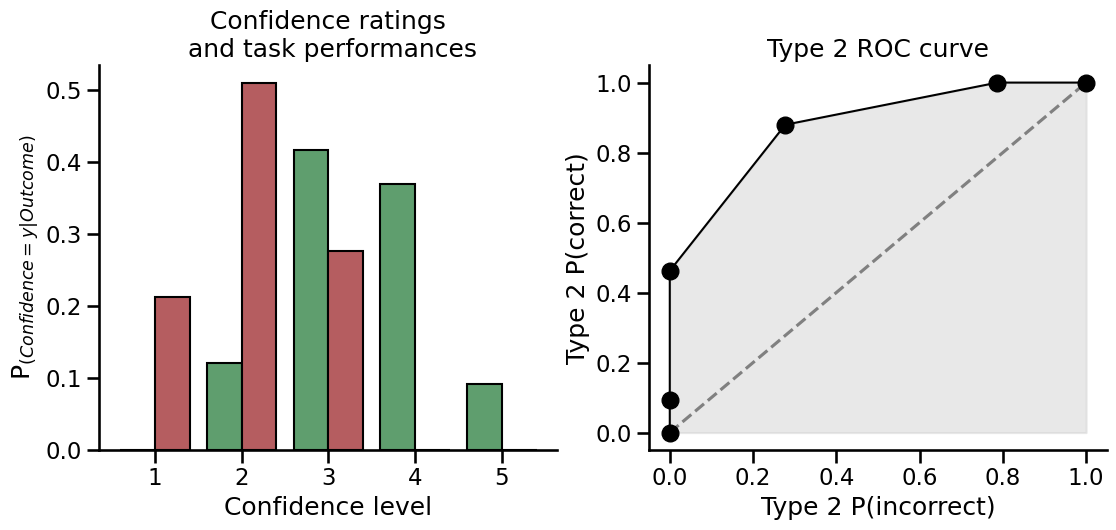

In [29]:
##1. Plot Confidence function, what is going on under the hood
##2. Dive deep into ROC, specifically in the context of 2012 paper and this plot. Are they the same curve(figure out labelling, figure out what's going on under the hood)
##3. Understand why ROC curve useful for Meta-d' in general, how did they come up with meta-d' given roc-auc
##Questions to be answered
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
plot_confidence(nR_S1, nR_S2, ax=axs[0])
plot_roc(nR_S1, nR_S2, ax=axs[1])
sns.despine()

**SDT Metrics**

In [30]:
##D-Prime
gpt2xlAI4MetaDPy.dprime()

1.1140137646718957

In [31]:
##Area under ROC Curve
gpt2xlAI4MetaDPy.roc_auc(nRatings=5)

0.8663069751381215

**Meta-d' with MLE**

My understanding of Meta-d' with MLE is as follows: You assume an equal-variance normal SDT model, where your variable x follows two normal distributions, one for s1(incorrectly classified) and for s2(correctly classified). We use a decision criterion c(in our case the threshold?). If x is greater than c(for plausible) or less than c(for implausible), we respond s2 else we respond s1. These c's take into account/are made up of our binned confidence ratings. For each confidence bin, we measure the probability of incorrect and incorrect based off our differences between c and our calculated d-prime(hit rate minus false alarm rate). This d-prime represents our meta-d'. We know have probabilities for s1 and s2 across confidence bins. We calculate the log likelihood given our counts and the probability. Our goal is to find the meta-d' and c combinations that optimize our log likelihood. We end up with an appropriate meta-d'.

In [32]:
##Look into behind the scenes
##Question to be answered/looked into
results = metad(
    data=gpt2xlAI4MetaDPy,
    nRatings=5,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    verbose=0,
)
results

,dprime,meta_d,m_ratio,m_diff
0,1.102771,2.124219,1.926256,1.021448


**Meta-d' with Bayesian Modeling**

This approach builds a hierarchical Bayesian model and samples from the posterior of the parameters. We want to estimate a posterior distribution over the model parameters, especially meta-d′, given the observed data (nR_S1, nR_S2) and our prior beliefs(knowledge of implausible or plausible(?), c condtions(?)). We go about calculating probabilities given our parameters similar to mle, but instead using the bayesian method. The model is compiled in PyMC. It uses the No-U-Turn Sampler (NUTS), an advanced Markov Chain Monte Carlo (MCMC) method, to sample from the posterior.

In [81]:
##Look into behind the scenes
##Question to be answered/looked into
model, trace = hmetad(
    data=gpt2xlAI4MetaDPy,
    nR_S1=nR_S1,
    nR_S2=nR_S2,
    nRatings=5,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    num_samples=100,
    num_chains=5
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [c1, d1, meta_d, cS1_hn, cS2_hn]


Output()

Sampling 5 chains for 1_000 tune and 100 draw iterations (5_000 + 500 draws total) took 3 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


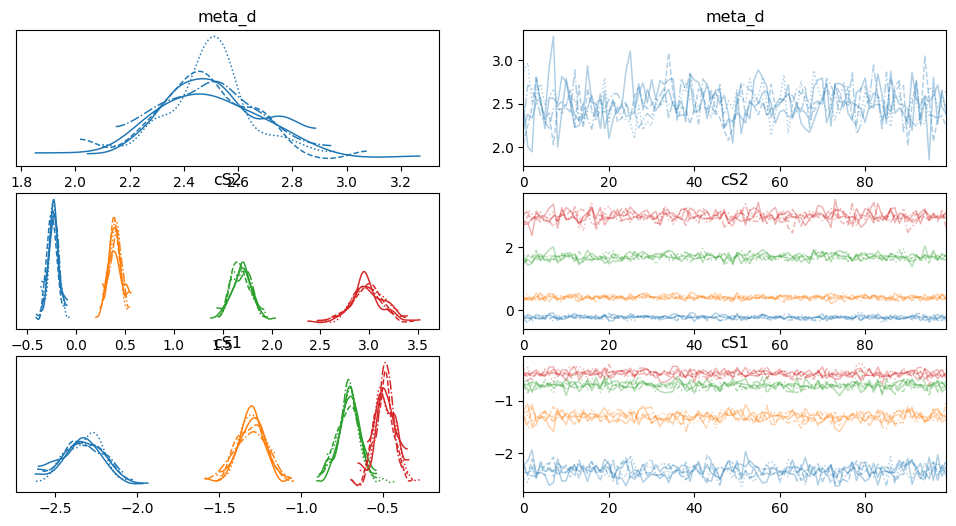

In [26]:
az.plot_trace(trace, var_names=["meta_d", "cS2", "cS1"]);